In [48]:
from BigDFT import Datasets as D, Calculators as C, Inputfiles as I, Logfiles as lf
from BigDFT.Database import Molecules
import numpy as np
import sys,os
sys.path.insert(0,'../')
import StatPol as SP
basepath = os.getcwd()
basepath

'/home/dalessandro/work/Statical_polarizability/Calculations'

In [49]:
omp = 2
mpi_run = 'mpirun -np 8'

# Workflow

This notebook contains the complete workflow to extract the statical polarizability of the HG dataset.

In this workflow we choose a set of values for the intensity of the field and, for each value, we perform a convergence analysis on the value of rmult

## Construction of the relevant tools

Define the functions needed to perform the workflow

In [50]:
# Service functions 

def change_workdir(molecule,study,datadir):
    """
    Ensure that the path Data_directory/molecule exists and
    move there. 
    """
    from futile.Utils import ensure_dir
    for d in [datadir,molecule]:
        ensure_dir(d)
        os.chdir(d)
    path='-'.join(study)
    ensure_dir(path)
    return '-'.join([molecule,path]),path

def get_psp(molecule):
    """
    Check if the all the atoms of molecule have the nlcc of the type nlss_aw and nlcc_ss. 
    If it is true the corresponding pseudo is added to the list of psp to be performed, otherwise 
    only hgh_k is included.
    """
    from os import path as p
    import Routines as R
    possible_psp=['nlcc_aw','nlcc_ss']
    to_do=[True,True]
    for at in R.get_atoms(molecule):
        psp_available = [p.isfile(p.join('psp_'+psp,'psppar.'+at)) for psp in possible_psp]
        to_do = [ a and b for a,b in zip(to_do,psp_available)]
    return ['hgh_k'] + [psp for yes,psp in zip(to_do,possible_psp) if yes]

def split_dataset(dataset,length=10):
    """
    Split a list of molecules into a list of list with length elements. 
    """
    splitted = [[] for num in range(int(len(dataset)/length)+1)]
    for ind,mol in enumerate(dataset):
        splitted[int(ind/length)].append(mol)
    return splitted

In [4]:
# Tools for the ground state

def get_converged_input_energy(dataset,rtol,atol):
    data=dataset.seek_convergence(atol=atol,rtol=rtol,attribute='energy')
    return dataset.runs[dataset.names.index(D.name_from_id(data[0]))]['input'],data[1]

def find_gs_domain(label,rtol,atol,path,input,posinp,code):
    """
    Use the seek_convergence method of Dataset to perform a convergence procedure on
    the rmult value for a gs computation.
    """
    crmult=input['dft']['rmult'][0]
    rmult_fine=input['dft']['rmult'][1]
    rmult_list=map(float,range(int(crmult),11))
    seek_for_rmult = D.Dataset(label=label+'(GS)',run_dir=path,posinp=posinp)
    for rm in rmult_list:
        input.set_rmult(coarse=rm,fine=rmult_fine)
        seek_for_rmult.append_run(id={'rmult':rm},runner=code,input=input)
    input_gs,log_gs=get_converged_input_energy(seek_for_rmult,rtol,atol)
    return {'input_gs':input_gs, 'dataset_gs': seek_for_rmult,'log_gs':log_gs}

def gs_study(molecule,study,code,options):
    """"
    Workflow for the convergence analysis of the ground state.
    
    Args : 
       molecule (str) : name of the molecule
       study (touple) : the couple (xc,psp)
       code (runner)  : instance of SystemCalculator
       options (dict) : dictionary with the computational options
    """
    import Routines as R
    hgrids=options.get('hgrids')
    rmult_fine=options.get('rmult_fine')
    wf_convergence=options.get('wf_convergence')
    crmult_start=options.get('crmult',4.0)
    rtol=options.get('rtol_gs',10*wf_convergence)
    atol=options.get('atol_gs',1.e-3)
    reference_results=options.get('reference_data')
    datadir=options.get('data_directory','Data')

    initial_dir=os.path.abspath(os.path.dirname('.'))
    label,path=change_workdir(molecule,study,datadir)
    
    posinp=Molecules.Molecule(molecule)
    
    inp = I.Inputfile()
    inp.set_hgrid(hgrids)
    inp.set_rmult(coarse=crmult_start,fine=rmult_fine)
    R.set_xc[study](inp,molecule,datadir)
    inp.set_wavefunction_convergence(wf_convergence)
    mpol=int(reference_results[molecule]['mpol_ref'])-1   
    if mpol >0: inp.spin_polarize(mpol)
    data= find_gs_domain(label,10*wf_convergence,atol,path,inp,posinp,code)
    os.chdir(initial_dir)
    
    data['molecule']=molecule
    data['posinp']=posinp
    data['study']=study
    return data 

In [5]:
# Tools for alpha
def extract_statical_polarizability(label,rtol,atol,path,input_for_alpha,posinp,code,ref):
    
    # seek for the field convergence
    ints=[1e-2,5e-3,1e-3,5e-4,1e-4]
    alpha_field=D.Dataset(label=label+'(field)',run_dir=path)
    for f in ints:
        alpha_field.append_run(id={'f':f},runner=SP.build_alpha_dataset(input=input_for_alpha,posinp=posinp,run_dir=path,runner=code,intensity=f))
    try:
        data_field=alpha_field.seek_convergence(rtol=rtol,atol=atol)
        intensity=data_field[0]['f']
    except:
        print ('Convergence in field not reached')
        intensity=ints[-1]
    
    # seek for the rmult convergence
    rmult_fine=input_for_alpha['dft']['rmult'][1]
    rmult_list=map(float,range(int(input_for_alpha['dft']['rmult'][0]),11))
    alpha_rmult=D.Dataset(label=label+'(domain)',run_dir=path)
    for rm in rmult_list:
        input_for_alpha.set_rmult(coarse=rm,fine=rmult_fine)
        alpha_rmult.append_run(id={'f':intensity,'rmult':rm},runner=SP.build_alpha_dataset(input=input_for_alpha,posinp=posinp,run_dir=path,runner=code,intensity=intensity))
    try:
        import numpy as np
        data_final=alpha_rmult.seek_convergence(rtol=rtol,atol=atol)
        AuToA = 0.5291772085**3
        alpha_ref_ii = np.array(ref)/AuToA
        eps = 100.0 * (data_final[1]-alpha_ref_ii)/alpha_ref_ii
        print ('Relative difference in %',eps.tolist())
    except LookupError as e:
        print ('Convergence in domain not reached',e)
        data_final=None
    return {'alpha_convergence': data_final, 'dataset_field': alpha_field, 'dataset_rmult': alpha_rmult}

def extract_statical_polarizability_linearity(label,rtol,atol,path,input_for_alpha,posinp,code,ref):
    
    #ints=[1e-2,5e-3,1e-3,5e-4,1e-4]
    ints= [1e-3,2e-3,3e-3,4e-3,5e-3] #for comparison with the MWL plots
       
    results = {}
    results['alpha_values'] = {}
    rmult_fine=input_for_alpha['dft']['rmult'][1]
    rmult_list=map(float,range(int(input_for_alpha['dft']['rmult'][0]),12))
    for intensity in ints:
    
        # seek for the rmult convergence
        alpha_rmult=D.Dataset(label=label+'(domain)',run_dir=path)
        for rm in rmult_list:
            input_for_alpha.set_rmult(coarse=rm,fine=rmult_fine)
            alpha_rmult.append_run(id={'f':intensity,'rmult':rm},\
                runner=SP.build_alpha_dataset(input=input_for_alpha,posinp=posinp,run_dir=path,\
                            runner=code,intensity=intensity))
    
        try:
            import numpy as np
            data_final=alpha_rmult.seek_convergence(rtol=rtol,atol=atol)
            AuToA = 0.5291772085**3
            alpha_ref_ii = np.array(ref)/AuToA
            eps = 100.0 * (data_final[1]-alpha_ref_ii)/alpha_ref_ii
            print ('Relative difference in %',eps.tolist())
        except LookupError as e:
            print ('Convergence in domain not reached',e)
            data_final=None
        
        results['alpha_values'][intensity] = {'alpha_convergence': data_final, 'dataset_rmult': alpha_rmult}
    return results

def alpha_study(gs_data,code,options):
    """"
    Workflow for the convergence analysis for the computation of alpha.
    
    Args : 
       gs_data        : output of gs_study
       code (runner)  : instance of SystemCalculator
       options (dict) : dictionary with the computational options
    """
    import copy
    xc_conversion={'lda_pw': 'lda-SPW92', 'pbe': 'pbe', 'pbe0': 'pbe0'}
    rtol=options.get('rtol',1.e-2)
    atol=options.get('atol',1.e-3)
    reference_results=options.get('reference_data')
    datadir=options.get('data_directory','Data')
    study=gs_data['study']
    molecule=gs_data['molecule']
    posinp=gs_data['posinp']
    xc=study[0]
    ref_data=reference_results[molecule][xc_conversion[xc]]
    
    initial_dir=os.path.abspath(os.path.dirname('.'))
    label,path=change_workdir(molecule,study,datadir)
    input_gs=copy.deepcopy(gs_data['input_gs'])
        
    #data=extract_statical_polarizability(label,rtol,atol,path,input_gs,posinp,code,ref=ref_data)
    data=extract_statical_polarizability_linearity(label,rtol,atol,path,input_gs,posinp,code,ref=ref_data)
    os.chdir(initial_dir)
    
    return data

In [6]:
def data_to_save(data,options):
    """
    Define the dictionary to be saved on file for data analysis
    """
    from copy import deepcopy
    res = {}
    for s,values in data.iteritems():
        res[s] = {}
        if not (values['alpha_convergence'] is None):
            res[s]['alpha_convergence'] = (values['alpha_convergence'][0],values['alpha_convergence'][1].tolist())
        else : 
            res[s]['alpha_convergence'] = values['alpha_convergence']
        
        res[s]['posinp'] = {}
        pos = values['posinp']
        for key in pos:
            res[s]['posinp'][key] = pos[key]
        
        res[s]['input_gs'] = {}
        inp = values['input_gs']
        for key in inp:
            res[s]['input_gs'][key] = inp[key]
        
    save_options = deepcopy(options)
    save_options.pop('reference_data')
    res['options'] = save_options
    return res

def data_to_save_linearity(data,options):
    """
    Define the dictionary to be saved on file for data analysis
    """
    from copy import deepcopy
    res = {}
    for s,values in data.iteritems():
        res[s] = {}
        res[s]['alpha_values'] = {}
        alpha_values = values['alpha_values']
        for f,v in alpha_values.iteritems():
            res[s]['alpha_values'][f] = {}
            if not (v['alpha_convergence'] is None):
                res[s]['alpha_values'][f]['alpha_convergence'] = (v['alpha_convergence'][0],v['alpha_convergence'][1].tolist())
            else: 
                res[s]['alpha_values'][f]['alpha_convergence'] = v['alpha_convergence']
        
        res[s]['posinp'] = {}
        pos = values['posinp']
        for key in pos:
            res[s]['posinp'][key] = pos[key]
        
        res[s]['input_gs'] = {}
        inp = values['input_gs']
        for key in inp:
            res[s]['input_gs'][key] = inp[key]
        
    save_options = deepcopy(options)
    save_options.pop('reference_data')
    res['options'] = save_options
    return res

## Single study analysis - linearity test

Build the dataset using the HG data written in hg_data.yaml. To each molecule of the dataset associate a set of studies=(xc,psp)

In [23]:
import yaml
HG_data=yaml.load(open('../HG Dataset/hg_data.yaml'))

In [24]:
code=C.SystemCalculator(omp=omp,mpi_run=mpi_run,skip=True,verbose=False)

Initialize a Calculator with OMP_NUM_THREADS=2 and command mpirun -np 8 /home/dalessandro/Applications/BigDFT/binaries/v1.8.4/install/bin/bigdft


In [25]:
options={'wf_convergence':1.e-6,'hgrids':0.3,'rmult_fine':9.0,'rtol':1.e-3,'atol':1.e-3,\
         'reference_data':HG_data,'data_directory':'Data'}

We can perform a single study with this workflow

In [26]:
study_data = {}

In [27]:
studies = [('Na','pbe','hgh_k'),('Li','pbe','nlcc_ss'),('NO','pbe','nlcc_ss')]

In [28]:
ind = 2
molecule = studies[ind][0]
xc = studies[ind][1]
psp = studies[ind][2]
print molecule,xc,psp

NO pbe nlcc_ss


In [29]:
HG_data[molecule]

{'CCSD(T)': [1.488, 1.488, 2.193],
 'lda-SPW92': [1.676, 1.676, 2.379],
 'lda-Slater': [1.888, 1.888, 2.572],
 'mpol_ref': '2',
 'pbe': [1.687, 1.687, 2.402],
 'pbe0': [1.536, 1.536, 2.289],
 'spin_pol': 'sp'}

In [30]:
gs_data=gs_study(molecule,(xc,psp),code,options)

Fetching results for id " {'rmult': 4.0} "
Fetching results for id " {'rmult': 5.0} "
Fetching results for id " {'rmult': 6.0} "
Convergence reached in Dataset "NO-pbe-nlcc_ss(GS)" for id " {'rmult': 5.0} "


In [31]:
#gs_data

In [ ]:
study_data[(molecule,xc,psp)]=alpha_study(gs_data,code,options)
study_data[(molecule,xc,psp)].update(gs_data)

Fetching results for id " {'rmult': 5.0, 'f': 0.001} "
Fetching results for id " {'rmult': 6.0, 'f': 0.001} "
Fetching results for id " {'rmult': 7.0, 'f': 0.001} "
Fetching results for id " {'rmult': 8.0, 'f': 0.001} "
Fetching results for id " {'rmult': 9.0, 'f': 0.001} "
Fetching results for id " {'rmult': 10.0, 'f': 0.001} "
Convergence reached in Dataset "NO-pbe-nlcc_ss(domain)" for id " {'rmult': 9.0, 'f': 0.001} "
('Relative difference in %', [-14.101509467130782, -14.101509467130782, 0.05089807404173327])
Fetching results for id " {'rmult': 5.0, 'f': 0.002} "
Fetching results for id " {'rmult': 6.0, 'f': 0.002} "
Fetching results for id " {'rmult': 7.0, 'f': 0.002} "
Fetching results for id " {'rmult': 8.0, 'f': 0.002} "
Fetching results for id " {'rmult': 9.0, 'f': 0.002} "
Fetching results for id " {'rmult': 10.0, 'f': 0.002} "
Convergence reached in Dataset "NO-pbe-nlcc_ss(domain)" for id " {'rmult': 9.0, 'f': 0.002} "
('Relative difference in %', [-14.095492482781319, -14.0

In [17]:
#study_data[molecule,xc,psp].keys()

In [18]:
#bla = study_data[molecule,xc,psp]['alpha_values'][0.01]['dataset_rmult']
#print bla.ids
#print bla.calculators[2]['calc'].runs[0]

In [34]:
full_results_linearity = {}
full_results_linearity.update(data_to_save_linearity(study_data,options))
full_results_linearity

{'options': {'atol': 0.001,
  'data_directory': 'Data',
  'hgrids': 0.3,
  'rmult_fine': 9.0,
  'rtol': 0.001,
  'wf_convergence': 1e-06},
 ('NO',
  'pbe',
  'nlcc_ss'): {'alpha_values': {0.001: {'alpha_convergence': ({'f': 0.001,
      'rmult': 9.0},
     [9.7790625, 9.7790625, 16.217750000000002])},
   0.002: {'alpha_convergence': ({'f': 0.002, 'rmult': 9.0},
     [9.7797475, 9.7797475, 16.22077])},
   0.003: {'alpha_convergence': ({'f': 0.003, 'rmult': 9.0},
     [9.780851666666667, 9.780851666666667, 16.22466])},
   0.004: {'alpha_convergence': ({'f': 0.004, 'rmult': 9.0},
     [9.78241, 9.78241, 16.23087125])},
   0.005: {'alpha_convergence': ({'f': 0.005, 'rmult': 9.0},
     [9.784412,
      9.784412,
      16.238856000000002])}}, 'input_gs': {'dft': {'gnrm_cv': 1e-06,
    'hgrids': 0.3,
    'ixc': 11,
    'mpol': 1,
    'nspin': 2,
    'rmult': [5.0, 9.0]}}, 'posinp': {'positions': [{'N': [0.0, 0.0, 0.0],
     'frag': ['molecule', '0']},
    {'O': [0.0, 0.0, 1.1538], 'frag': ['m

## Multiple study analysis - linearity test

Prepare the code that will be used in a python script for automatic execution of many studies

In [35]:
import yaml
HG_data=yaml.load(open('../HG Dataset/hg_data.yaml'))
AuToA = 0.5291772085

In [36]:
code=C.SystemCalculator(omp=omp,mpi_run=mpi_run,skip=True,verbose=False)

Initialize a Calculator with OMP_NUM_THREADS=2 and command mpirun -np 8 /home/dalessandro/Applications/BigDFT/binaries/v1.8.4/install/bin/bigdft


In [37]:
options={'wf_convergence':1.e-6,'hgrids':0.3,'rmult_fine':9.0,'rtol':1.e-3,'atol':1.e-3,\
         'reference_data':HG_data,'data_directory':'Data'}

We can perform a single study with this workflow

In [38]:
studies = [('Na','pbe','hgh_k'),('Li','pbe','nlcc_ss'),('NO','pbe','nlcc_ss')]

In [39]:
study_data = {}

for study in studies:
    molecule = study[0]
    xc = study[1]
    psp = study[2]
    
    print 'Analysis of '+molecule+'-'+xc+'-'+psp
    gs_data=gs_study(molecule,(xc,psp),code,options)
    study_data[(molecule,xc,psp)]=alpha_study(gs_data,code,options)
    study_data[(molecule,xc,psp)].update(gs_data)
    
full_results_linearity = {}
#full_results_linearity = yaml.load(open('full_results_linearity.yaml'))

full_results_linearity.update(data_to_save_linearity(study_data,options))
with open('full_results_linearity.yaml', 'w') as outfile:
    yaml.dump(full_results_linearity, outfile, default_flow_style=False)


Analysis of Na-pbe-hgh_k
Fetching results for id " {'rmult': 4.0} "
Fetching results for id " {'rmult': 5.0} "
Fetching results for id " {'rmult': 6.0} "
Convergence reached in Dataset "Na-pbe-hgh_k(GS)" for id " {'rmult': 5.0} "
Fetching results for id " {'rmult': 5.0, 'f': 0.001} "
Fetching results for id " {'rmult': 6.0, 'f': 0.001} "
Fetching results for id " {'rmult': 7.0, 'f': 0.001} "
Fetching results for id " {'rmult': 8.0, 'f': 0.001} "
Fetching results for id " {'rmult': 9.0, 'f': 0.001} "
Fetching results for id " {'rmult': 10.0, 'f': 0.001} "
Convergence reached in Dataset "Na-pbe-hgh_k(domain)" for id " {'rmult': 9.0, 'f': 0.001} "
('Relative difference in %', [-0.3394891658877975, -0.3394891658877975, -0.3394891658877975])
Fetching results for id " {'rmult': 5.0, 'f': 0.002} "
Fetching results for id " {'rmult': 6.0, 'f': 0.002} "
Fetching results for id " {'rmult': 7.0, 'f': 0.002} "
Fetching results for id " {'rmult': 8.0, 'f': 0.002} "
Fetching results for id " {'rmult

Fetching results for id " {'rmult': 8.0, 'f': 0.005} "
Fetching results for id " {'rmult': 9.0, 'f': 0.005} "
Fetching results for id " {'rmult': 10.0, 'f': 0.005} "
Convergence reached in Dataset "NO-pbe-nlcc_ss(domain)" for id " {'rmult': 9.0, 'f': 0.005} "
('Relative difference in %', [-14.05451989373297, -14.05451989373297, 0.1811056709494848])


In HG Li is computed width field intensity 0.01

In HG Na is computed width field intensity 0.01

In [40]:
for study in studies:
    print 'Ref for ' + study[0] + ' = ' + str(np.array(HG_data[study[0]][study[1]])/(AuToA**3))

Ref for Na = [161.27169995 161.27169995 161.27169995]
Ref for Li = [152.59334167 152.59334167 152.59334167]
Ref for NO = [11.38444045 11.38444045 16.20949968]


In [41]:
full_results_linearity

{'options': {'atol': 0.001,
  'data_directory': 'Data',
  'hgrids': 0.3,
  'rmult_fine': 9.0,
  'rtol': 0.001,
  'wf_convergence': 1e-06},
 ('Li',
  'pbe',
  'nlcc_ss'): {'alpha_values': {0.001: {'alpha_convergence': ({'f': 0.001,
      'rmult': 9.0},
     [145.91500000000002, 145.91500000000002, 145.91500000000002])},
   0.002: {'alpha_convergence': ({'f': 0.002, 'rmult': 9.0},
     [146.310425, 146.310425, 146.310425])},
   0.003: {'alpha_convergence': ({'f': 0.003, 'rmult': 9.0},
     [146.99598333333333, 146.99598333333333, 146.99598333333333])},
   0.004: {'alpha_convergence': ({'f': 0.004, 'rmult': 9.0},
     [148.02894999999998, 148.02894999999998, 148.02894999999998])},
   0.005: {'alpha_convergence': ({'f': 0.005, 'rmult': 10.0},
     [149.70515,
      149.70515,
      149.70515])}}, 'input_gs': {'dft': {'gnrm_cv': 1e-06,
    'hgrids': 0.3,
    'ixc': 11,
    'mpol': 1,
    'nspin': 2,
    'rmult': [5.0, 9.0]}}, 'posinp': {'positions': [{'Li': [0.0, 0.0, 0.0],
     'frag': ['m

In [15]:
full_results = yaml.load(open('full_results.yaml'))

In [16]:
full_results[('Li','pbe','nlcc_ss')]

{'alpha_convergence': ({'f': 0.001, 'rmult': 9.0},
  [145.91500000000002, 145.91500000000002, 145.91500000000002]),
 'input_gs': {'dft': {'gnrm_cv': 1e-06,
   'hgrids': 0.3,
   'ixc': 11,
   'mpol': 1,
   'nspin': 2,
   'rmult': [5.0, 9.0]}},
 'posinp': {'positions': [{'Li': [0.0, 0.0, 0.0], 'frag': ['molecule', '0']}],
  'units': 'angstroem'}}

It seems that for Li the 4% is due to the fact that HG data are computed for a field that is outside the linear range

In [17]:
full_results[('Na','pbe','hgh_k')]

{'alpha_convergence': ({'f': 0.001, 'rmult': 9.0},
  [160.72419999999997, 160.72419999999997, 160.72419999999997]),
 'input_gs': {'dft': {'gnrm_cv': 1e-06,
   'hgrids': 0.3,
   'ixc': 11,
   'mpol': 1,
   'nspin': 2,
   'rmult': [5.0, 9.0]}},
 'posinp': {'positions': [{'Na': [0.0, 0.0, 0.0], 'frag': ['molecule', '0']}],
  'units': 'angstroem'}}

# Data analysis

In [42]:
import matplotlib.pyplot as plt
AuToA = 0.5291772085

## Induced dipoles vs field intensity

In [47]:
#full_results_linearity = yaml.load(open('full_results_linearity.yaml'))

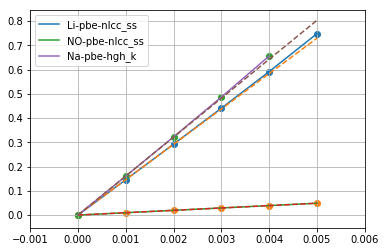

In [46]:
for study in full_results_linearity:
    if study == 'options': continue
    #print study
    alphas = full_results_linearity[study]['alpha_values']
    #print alphas
    ints = alphas.keys()
    ints.append(0.0)
    ints.sort()
    #print ints
    dipoles = []
    dipoles.append(0.0)
    for f in ints[1:]:
        if alphas[f]['alpha_convergence'] is not None:
            dip = f*alphas[f]['alpha_convergence'][1][0]#/(AuToA**3)
            dipoles.append(dip)
        else: dipoles.append(None)
    plt.plot(ints,dipoles,label = study[0]+'-'+study[1]+'-'+study[2])
    plt.scatter(ints,dipoles)
    coeff = dipoles[1]/ints[1]
    linear_dip = [coeff*x for x in ints]
    plt.plot(ints,linear_dip,linestyle='--')
plt.xlim(-0.001,0.006)
plt.grid()
plt.legend()      

## Mean error analysis

In [ ]:
def mean_relative_error(alpha,alpha_ref):
    """
    Provide the mean relative error
    """
    return 100.0*np.mean((alpha-alpha_ref)/alpha_ref)

In [ ]:
HG_data[molecule][xc]

We build a dictionary with the mean relative errors

In [ ]:
mre_data = {}
for (mol,xc,psp),data in study_data.iteritems():
    mre_data[mol,xc,psp] = {}
    for ints,alphas in data['alpha_values'].iteritems():
        alpha = np.array(alphas['alpha_convergence'][1])
        alpha_ref = np.array(HG_data[molecule][xc])/(AuToA**3)
        mre_data[mol,xc,psp][ints] = mean_relative_error(alpha,alpha_ref)

In [ ]:
mre_data

Compare with the standard results

In [ ]:
full_results=yaml.load(open('full_results.yaml'))

In [ ]:
full_results['Na','pbe','hgh_k']

## Function for the id

In [68]:
inp = I.Inputfile()
inp.set_hgrid(0.32)
inp.set_rmult(coarse=8.0,fine=9.0)
#R.set_xc[study](inp,molecule,datadir)
inp.set_wavefunction_convergence(1.1e-6)
inp

{'dft': {'gnrm_cv': 1.1e-06, 'hgrids': 0.32, 'rmult': [8.0, 9.0]}}

For alpha the id is like

In [69]:
idd_alpha = {'rmult':inp['dft']['rmult'][0],'dir':'x','sign':'+','F':0.001,'hgrids':inp['dft']['hgrids'],\
             'gnrm_cv':inp['dft']['gnrm_cv']}
idd_alpha

{'F': 0.001,
 'dir': 'x',
 'gnrm_cv': 1.1e-06,
 'hgrids': 0.32,
 'rmult': 8.0,
 'sign': '+'}

For the gs the id is like

In [70]:
idd_gs = {'rmult':inp['dft']['rmult'][0],'hgrids':inp['dft']['hgrids'],\
             'gnrm_cv':inp['dft']['gnrm_cv']}
idd_gs

{'gnrm_cv': 1.1e-06, 'hgrids': 0.32, 'rmult': 8.0}

In [71]:
def process_id_default_values(idd):
    """
    Process the idd and remove the keys hgrids and gnrm_cv (if present)
    if the associated values are the default ones (i.e. 0.3 and 1e-06)
    """
    from copy import deepcopy
    out = deepcopy(idd)
    if 'hgrids' in out.keys():
        if out['hgrids'] == 0.3:
            out.pop('hgrids')
    if 'gnrm_cv' in out.keys():
        if out['gnrm_cv'] == 1e-06:
            out.pop('gnrm_cv')

    return out

In [72]:
process_id_default_values(idd_alpha)

{'F': 0.001,
 'dir': 'x',
 'gnrm_cv': 1.1e-06,
 'hgrids': 0.32,
 'rmult': 8.0,
 'sign': '+'}

In [73]:
process_id_default_values(idd_gs)

{'gnrm_cv': 1.1e-06, 'hgrids': 0.32, 'rmult': 8.0}